# [Advanced] 対称性を考慮した構造最適化

前章で基本的な事例に対する構造最適化を学びました。
本章はより発展的な内容として、系の対称性を保ちながら構造最適化を行う方法について学びます。

ASEでは空間群 (spacegroup)を扱う機能があり、 `FixSymmetry` というConstraintsクラスを利用することで対称性を考慮した構造最適化が行なえます。

 - [Using the spacegroup subpackage](https://databases.fysik.dtu.dk/ase/ase/spacegroup/spacegroup.html)
 - [FixSymmetry Constraints](https://wiki.fysik.dtu.dk/ase/ase/constraints.html#the-fixsymmetry-class)



本章は発展的な位置付けとします。次章へ急ぎたい方はスキップし、後から読んでいただいても構いません。

## BaTiO3 の構造最適化

空間群や本章でいう"対称性"とは何なのかの詳細説明の前に、具体例を見ていきます。

ここでは[ペロブスカイト構造](https://ja.wikipedia.org/wiki/%E3%83%9A%E3%83%AD%E3%83%96%E3%82%B9%E3%82%AB%E3%82%A4%E3%83%88%E6%A7%8B%E9%80%A0)をもつ物質として知られる、BaTiO3(チタン酸バリウム)の構造最適化を考えてみます。

BaTiO3は高い比誘電率を持つことからセラミック積層コンデンサなどの誘電体材料として使用されている人工鉱物で、室温では[正方晶](https://ja.wikipedia.org/wiki/%E6%AD%A3%E6%96%B9%E6%99%B6%E7%B3%BB) (tetragonal)の構造をとっています。詳しくは、以下のページが参考になります。

 - [チタン酸バリウム - Wikipedia](https://ja.wikipedia.org/wiki/%E3%83%81%E3%82%BF%E3%83%B3%E9%85%B8%E3%83%90%E3%83%AA%E3%82%A6%E3%83%A0)

構造ファイルはMaterials Projectより取得しています。

 - https://materialsproject.org/materials/mp-5986/

Input cif file is from  
A. Jain*, S.P. Ong*, G. Hautier, W. Chen, W.D. Richards, S. Dacek, S. Cholia, D. Gunter, D. Skinner, G. Ceder, K.A. Persson (*=equal contributions)  
The Materials Project: A materials genome approach to accelerating materials innovation
APL Materials, 2013, 1(1), 011002.  
[doi:10.1063/1.4812323](http://dx.doi.org/10.1063/1.4812323)  
[[bibtex]](https://materialsproject.org/static/docs/jain_ong2013.349ca3156250.bib)  
Licensed under [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/)  

以下の正方晶(tetragonal)構造を持つBaTiO3のセルは、$a = b \neq c$, $\alpha = \beta = \gamma = $ 90°となっています。($a = b = c$, $\alpha = \beta = \gamma = $ 90°の場合は[立方晶](https://ja.wikipedia.org/wiki/%E7%AB%8B%E6%96%B9%E6%99%B6%E7%B3%BB) (cubic)となります。)

In [1]:
from ase.io import read
from pfcc_extras.visualize.view import view_ngl

bto_tetra = read("../input/BaTiO3_mp-5986_computed.cif")
print(f"BaTiO3 (Tetragonal): cell = {bto_tetra.cell.cellpar()}")
view_ngl(bto_tetra, representations=[])

BaTiO3 (Tetragonal): cell = [ 4.004457  4.004457  4.200636 90.       90.       90.      ]


In [2]:
view_ngl(bto_tetra * (4, 4, 4), representations=[])

`get_scaled_positions`関数を用いると、各原子の絶対座標ではなく、ユニットセルにおける相対座標を得ることができます。(つまり、`[0, 0, 0]`を原点、`[1, 1, 1]` がユニットセルの逆端の点となるような座標スケールです。)

今回の構造で`scaled_positions`を確認してみると、xy座標に関しては `0`や`0.5` といったきりの良い数字をとっていることがわかります。

In [3]:
bto_tetra.get_scaled_positions()

array([[0.5     , 0.5     , 0.004136],
       [0.      , 0.      , 0.524313],
       [0.      , 0.5     , 0.479349],
       [0.5     , 0.      , 0.479349],
       [0.      , 0.      , 0.958854]])

この構造に対して、

 - 本章で説明する、`FixSymmetry` を用いる・用いない場合
 - 前章で説明済みの`ExpCellFilter`の`hydrostatic_strain` が `True`, `False` の場合

の以下4通りの方法で構造最適化してみましょう。



In [4]:
import pfp_api_client
from pfp_api_client.pfp.calculators.ase_calculator import ASECalculator
from pfp_api_client.pfp.estimator import Estimator, EstimatorCalcMode


estimator = Estimator(calc_mode=EstimatorCalcMode.CRYSTAL, model_version="v2.0.0")
calculator = ASECalculator(estimator)

構造最適化前のポテンシャルエネルギー

In [5]:
bto_tetra.calc = calculator
Epot = bto_tetra.get_potential_energy()
print(f"Epot before opt: {Epot} eV")

Epot before opt: -31.497284641756742 eV


In [6]:
from ase import Atoms
from ase.calculators.calculator import Calculator
from ase.constraints import ExpCellFilter
from ase.optimize import FIRE
from ase.spacegroup.symmetrize import FixSymmetry


def opt_with_symmetry(
    atoms_in: Atoms,
    calculator: Calculator,
    fix_symmetry: bool = False,
    hydrostatic_strain: bool = False,
) -> Atoms:
    atoms = atoms_in.copy()
    atoms.calc = calculator
    if fix_symmetry:
        atoms.set_constraint([FixSymmetry(atoms)])
    ecf = ExpCellFilter(atoms, hydrostatic_strain=hydrostatic_strain)
    opt = FIRE(ecf, logfile=None)
    opt.run(fmax=0.005)

    cell_diff = (atoms.cell.cellpar() / atoms_in.cell.cellpar() - 1.0) * 100
    print("Optimized Cell         :", atoms.cell.cellpar())
    print("Optimized Cell diff (%):", cell_diff)
    print("Scaled positions       :\n", atoms.get_scaled_positions())
    print(f"Epot after opt: {atoms.get_potential_energy()} eV")
    return atoms


### 1. FixSymmetryなし, hydrostatic_strain=False

結晶軸のa, b, c, $\alpha, \beta, \gamma$ が全て独立に最適化されるため、ごく僅かではありますが角度が90°からずれるなど、正方晶の対称性が崩れてしまっていることがわかります。原子座標も自由に動いています。

In [7]:
atoms1 = opt_with_symmetry(bto_tetra, calculator, fix_symmetry=False, hydrostatic_strain=False)

Optimized Cell         : [ 3.99967731  3.9996773   4.26208123 90.00000122 90.0000008  90.0000006 ]
Optimized Cell diff (%): [-1.19359194e-01 -1.19359477e-01  1.46276021e+00  1.35654450e-06
  8.93428309e-07  6.63874755e-07]
Scaled positions       :
 [[4.99999981e-01 4.99999971e-01 1.29638575e-02]
 [9.99999890e-01 9.99999803e-01 5.27750427e-01]
 [3.17677469e-08 5.00000134e-01 4.76041077e-01]
 [5.00000085e-01 7.18399746e-08 4.76041081e-01]
 [1.32416459e-08 1.94824495e-08 9.53204558e-01]]
Epot after opt: -31.50062584975033 eV


### 2. FixSymmetryあり, hydrostatic_strain=False

正方晶(tetragonal)構造の持つ対称性である、$a = b \neq c$, $\alpha = \beta = \gamma = $ 90°を保ちつつきちんと最適化ができており、**今回の構造最適化における所望の結果が得られる**ことがわかります。

また、xy座標の`scaled_positions`も`0`や`0.5` といったきりの良い数字を(ものすごく小さな数値誤差を除いて)保っていることがわかります。<br/>
※ これは後述する `P 4 m m` という対称性に課されるサイト間の関係を保っているということになります。

In [8]:
atoms2 = opt_with_symmetry(bto_tetra, calculator, fix_symmetry=True, hydrostatic_strain=False)

Optimized Cell         : [ 3.99967962  3.99967962  4.26208589 90.         90.         90.        ]
Optimized Cell diff (%): [-0.11930149 -0.11930149  1.46287109  0.          0.          0.        ]
Scaled positions       :
 [[5.00000000e-01 5.00000000e-01 1.29642674e-02]
 [0.00000000e+00 0.00000000e+00 5.27750504e-01]
 [0.00000000e+00 5.00000000e-01 4.76040903e-01]
 [5.00000000e-01 1.68532369e-34 4.76040903e-01]
 [0.00000000e+00 4.81521053e-34 9.53204423e-01]]
Epot after opt: -31.50062774984776 eV


### 3. FixSymmetryなし, hydrostatic_strain=True

`hydrostatic_strain=True`の場合、等方的に圧力がかかるよう補正をするので、格子長の比と格子角を維持して最適化されます。
Optimized Cell diff (%)の部分を見るとわかるように、角度が90°なまま最適化できていますが、a, b, c軸が全て同じ比率で最適化されてしまっています。
結果として、c軸方向に伸びる構造最適化が進まずに極小値まで落ちきれていない事がわかります。(1, 2と比べると `Epot`が大きい値で構造最適化が終了してしまっています。)

また、原子座標に関しては自由に動くため、xy座標の`scaled_positions`が`0`や`0.5` といったきりの良い数字から少し離れていることがわかります。

In [9]:
atoms3 = opt_with_symmetry(bto_tetra, calculator, fix_symmetry=False, hydrostatic_strain=True)

Optimized Cell         : [ 4.01270313  4.01270313  4.20928611 90.         90.         90.        ]
Optimized Cell diff (%): [0.20592371 0.20592371 0.20592371 0.         0.         0.        ]
Scaled positions       :
 [[5.00000008e-01 4.99999994e-01 9.89108271e-03]
 [1.11106572e-08 9.99999911e-01 5.24864351e-01]
 [9.99999987e-01 5.00000061e-01 4.77019937e-01]
 [4.99999994e-01 2.14225119e-08 4.77019929e-01]
 [2.15720326e-10 1.25089468e-08 9.57205700e-01]]
Epot after opt: -31.4997303967836 eV


### 4. FixSymmetryあり, hydrostatic_strain=True

セルに関しては3.と同様の結果となりました。`hydrostatic_strain=True`として格子長の比と格子角を維持するということが、`FixSymmetry`で課される制約よりも厳しいものとなっています。

原子座標に関しては`FixSymmetry`の制約により、xy座標の`scaled_positions`が`0`や`0.5` といったきりの良い数字を保っています。

In [27]:
atoms4 = opt_with_symmetry(bto_tetra, calculator, fix_symmetry=True, hydrostatic_strain=True)

Optimized Cell         : [ 4.01270314  4.01270314  4.20928612 90.         90.         90.        ]
Optimized Cell diff (%): [0.20592401 0.20592401 0.20592401 0.         0.         0.        ]
Scaled positions       :
 [[5.00000000e-01 5.00000000e-01 9.89107701e-03]
 [0.00000000e+00 3.11088259e-43 5.24864324e-01]
 [0.00000000e+00 5.00000000e-01 4.77019942e-01]
 [5.00000000e-01 1.96181785e-43 4.77019942e-01]
 [0.00000000e+00 0.00000000e+00 9.57205715e-01]]
Epot after opt: -31.499728636465193 eV


### まとめ

結果を表にまとめると以下のようになります。

| 方法 | `FixSymmetry` | `hydtrostatic_strain` | 結果 |
|:------|:------:|:---------:|:---------|
| 1 |  | | 対称性が考慮されないため、セルの角度などが微小変化してしまう。 |
| 2 | ✓ |  | <b>所望の結果が得られる。</b>正方晶という対称性を保ちながら、十分な構造最適化が行える。<br/>原子座標のサイトの関係もきちんと制約がかかる |
| 3 |  | ✓ | a, b, c軸全てが同じ割合で最適化されてしまうため、c軸方向の構造最適化が十分に行えない。<br/>原子座標も自由に動いてしまう。 |
| 4 | ✓ | ✓ | セルは3と同様。原子座標のサイトの関係は制約がかかる。 |


**格子の対称性とは「格子ベクトル・等価であるサイトの関係」のことであり（a=b, α=β=γ=90°など）**、`FixSymmetry`を用いることでこの対称性を保ちながら構造最適化を行えます。より正確には、初期構造が属する**空間群を保つ**ような変位のみで構造最適化が行われます。

以下では、対称性に関する定義、つまり空間群について説明します。

## 空間群 (spacegroup)

3次元の空間に周期境界条件をもって規則的に続く結晶構造が取ることのできるパターンは、全部で**230種類**となることが知られており、これを空間群といいます。
全ての結晶は230種類の空間群のなかのどれか１つに属することとなります。

 - [空間群](https://ja.wikipedia.org/wiki/%E7%A9%BA%E9%96%93%E7%BE%A4)

空間群の230種のリストに関しては、例えば以下のサイトなどで確認することができます。

 - [High-Resolution Space Group Diagrams and Tables](http://img.chem.ucl.ac.uk/sgp/large/sgp.htm)


ASEでは、`get_spacegroup`関数を用いることで`atoms`の空間群を判定することができます。

[Note]

`get_spacegroup`関数内では`spglib`というライブラリが内部で用いられています。<br/>
`spglib`は、ユニットセルや原子座標の情報から、その空間群を判定するライブラリです。

 - [Spglib Document](https://spglib.github.io/spglib/)
 - [github](https://github.com/spglib/spglib)
 - "`Spglib`: a software library for crystal symmetry search", Atsushi Togo and Isao Tanaka, https://arxiv.org/abs/1808.01590


今回のBaTiO3 tetragonal構造に対して、空間群の判定を行ってみましょう。

In [11]:
from ase.spacegroup import get_spacegroup

sg = get_spacegroup(bto_tetra)
sg

Spacegroup(99, setting=1)

ここで返ってきた `Spacegroup` クラスからは以下のような情報を得ることができます。

 - `no`: 空間群の番号
 - `symbol`: 空間群の[ヘルマン・モーガン記号](https://ja.wikipedia.org/wiki/%E3%83%98%E3%83%AB%E3%83%9E%E3%83%B3%E3%83%BB%E3%83%A2%E3%83%BC%E3%82%AC%E3%83%B3%E8%A8%98%E5%8F%B7)([Hermann-Mauguin](https://en.wikipedia.org/wiki/Hermann%E2%80%93Mauguin_notation))。(他の表現方法としては[シェーンフリース記号](https://ja.wikipedia.org/wiki/%E3%82%B7%E3%82%A7%E3%83%BC%E3%83%B3%E3%83%95%E3%83%AA%E3%83%BC%E3%82%B9%E8%A8%98%E5%8F%B7)([Schoenflies](https://en.wikipedia.org/wiki/Schoenflies_notation))が知られています。)
 - `lattice`: 格子タイプ。`P` 単純格子, `I` 体心, `F` 面心など。
 - `scaled_primitive_cell`: 規格化された単位胞
 - `reciprocal_cell`: 逆格子

In [12]:
type(sg)

ase.spacegroup.spacegroup.Spacegroup

In [13]:
print("no      : ", sg.no)
print("symbol  : ", sg.symbol)
print("lattice : ", sg.lattice)
print("scaled_primitive_cell: \n", sg.scaled_primitive_cell)
print("reciprocal_cell      : \n", sg.reciprocal_cell)

no      :  99
symbol  :  P 4 m m
lattice :  P
scaled_primitive_cell: 
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
reciprocal_cell      : 
 [[1 0 0]
 [0 1 0]
 [0 0 1]]


今回のBaTiO3構造は、99番目の `P 4 m m` 空間群と判定されました。

 - P4mm: http://img.chem.ucl.ac.uk/sgp/large/099az1.htm

空間群は並進移動・回転・鏡像反転などのうち、どのような操作に対してその結晶構造が変わらない変換となるかを規定しています。<br/>
空間群の記号の読み方などに関しては、それだけで１冊の本になるほどの内容なので、ここでは割愛します。<br/>
詳細を勉強したい方は末尾の参考文献などをご参照ください。

本tutorialでは、可視化をしながら空間群がどういうものなのか感覚的な説明を試みます。
`P 4 m m` は、4回回転対称性を持ち(z軸方向に90度回転させる変換に対して不変)、xz平面およびyz平面に対して鏡像反転対称性を持つ空間群となっています。

ある１つの原子配置に対して、この対称性から課される"等価なサイト"は、`equivalent_lattice_points`という関数で計算できます。
以下のように、適当な点 (`[0.3, 0.1, 0.6]`)に対して等価なサイトを計算し、表示してみましょう。

In [14]:
sites, kinds = sg.equivalent_sites([[0.3, 0.1, 0.6]])
print("sites", sites)

p4mm_atoms = Atoms(symbols="C8", scaled_positions=sites, cell=[5, 5, 5], pbc=True)
view_ngl(p4mm_atoms)

sites [[0.3 0.1 0.6]
 [0.7 0.9 0.6]
 [0.9 0.3 0.6]
 [0.1 0.7 0.6]
 [0.3 0.9 0.6]
 [0.7 0.1 0.6]
 [0.9 0.7 0.6]
 [0.1 0.3 0.6]]


このように、`[0.3, 0.1, 0.6]`からz軸方向に90度回転して得られる点や、それらの点からxz平面/yz平面に対する鏡像反転を行って得られる点、合計8点が等価なサイトとして含まれることがわかります。

BaTiO3の構造を再度見てみましょう。

In [15]:
view_ngl(bto_tetra)

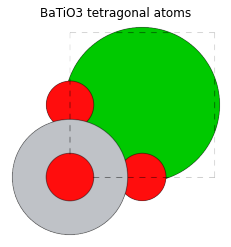

In [16]:
from pfcc_extras.visualize.ase import view_ase_atoms

view_ase_atoms(bto_tetra, figsize=(4, 4), title="BaTiO3 tetragonal atoms", scale=100, rotation="0x,0y,0z")

今回のBaTiO3構造に関しては、
`index=0`のBa、`index=1`のTi、`index=4`のOに関しては、回転や鏡像反転を行ってもユニットセル分の移動を除いて同じ場所に移るため、等価なサイトは自分自身のみとなっています。
`index2, 3`のO構造は4回回転対称性によりお互いに等価なサイトとなっていることがわかります。

In [17]:
spos = bto_tetra.get_scaled_positions()
symbols = bto_tetra.symbols

for i in range(len(spos)):
    print(i, symbols[i], sg.equivalent_sites(spos[i]))    

0 Ba (array([[0.5     , 0.5     , 0.004136]]), [0])
1 Ti (array([[0.      , 0.      , 0.524313]]), [0])
2 O (array([[0.      , 0.5     , 0.479349],
       [0.5     , 0.      , 0.479349]]), [0, 0])
3 O (array([[0.5     , 0.      , 0.479349],
       [0.      , 0.5     , 0.479349]]), [0, 0])
4 O (array([[0.      , 0.      , 0.958854]]), [0])


最後に、本tutorial で構造最適化を行った後の4構造それぞれに対する空間群の判定をしてみます。

`get_spacegroup`関数の`symprec` で対称性判定を行う際の各原子座標のずれの許容範囲を設定できます。
今回、defaultの`symprec=1e-5`では全て `P 4 m m`となってしまったため、厳しく小さな値を設定して空間群の判定を行っています。

In [18]:
symprec = 1e-10

print("atoms1: ", get_spacegroup(atoms1, symprec=symprec).symbol)
print("atoms2: ", get_spacegroup(atoms2, symprec=symprec).symbol)
print("atoms3: ", get_spacegroup(atoms3, symprec=symprec).symbol)
print("atoms4: ", get_spacegroup(atoms4, symprec=symprec).symbol)

atoms1:  P 1
atoms2:  P 4 m m
atoms3:  P 1
atoms4:  P 4 m m


このように `FixSymmetry` を適用した `atoms2`, `atoms4` は`P 4 m m` **空間群を保って**いますが、
`atoms1`, `atoms3` は空間群が崩れ、一番対称性の低い`P 1` になってしまっています。

 - 1  P1  : http://img.chem.ucl.ac.uk/sgp/large/001az1.htm
 - 99 P4mm: http://img.chem.ucl.ac.uk/sgp/large/099az1.htm

## ブラべー格子

空間群について説明を行ったので、関連する概念としてブラべー格子の説明をします。

 - [結晶構造 - Wikipedia](https://ja.wikipedia.org/wiki/%E7%B5%90%E6%99%B6%E6%A7%8B%E9%80%A0)
 - https://wiki.fysik.dtu.dk/ase/ase/lattice.html
 
空間群は`atoms`のセル及び原子配置双方に依存して決まる対称性ですが、ブラべー格子はセル(単位胞)のみから決まるものです。

ブラべー格子は以下の**14種類**のいずれかになることが知られています。
これら14種類は上記のwikipediaのリンクでも図示されているのでご確認ください。

In [19]:
from ase.lattice import CUB, FCC, BCC, TET, BCT, HEX, RHL, ORC, ORCF, ORCI, ORCC, MCL, MCLC, TRI

print(" 1. CUB:", CUB.longname, ",", CUB.crystal_family)
print(" 2. FCC:", FCC.longname, ",", FCC.crystal_family)
print(" 3. BCC:", BCC.longname, ",", BCC.crystal_family)
print(" 4. TET:", TET.longname, ",", TET.crystal_family)
print(" 5. BCT:", BCT.longname, ",", BCT.crystal_family)
print(" 6. HEX:", HEX.longname, ",", HEX.crystal_family)
print(" 7. RHL:", RHL.longname, ",", RHL.crystal_family)
print(" 8. ORC:", ORC.longname, ",", ORC.crystal_family)
print(" 9. ORCF:", ORCF.longname, ",", ORCF.crystal_family)
print("10. ORCI:", ORCI.longname, ",", ORCI.crystal_family)
print("11. ORCC:", ORCC.longname, ",", ORCC.crystal_family)
print("12. MCL :", MCL.longname, ",", MCL.crystal_family)
print("13. MCLC:", MCLC.longname, ",", MCLC.crystal_family)
print("14. TRI :", TRI.longname, ",", TRI.crystal_family)

 1. CUB: primitive cubic , cubic
 2. FCC: face-centred cubic , cubic
 3. BCC: body-centred cubic , cubic
 4. TET: primitive tetragonal , tetragonal
 5. BCT: body-centred tetragonal , tetragonal
 6. HEX: primitive hexagonal , hexagonal
 7. RHL: primitive rhombohedral , hexagonal
 8. ORC: primitive orthorhombic , orthorhombic
 9. ORCF: face-centred orthorhombic , orthorhombic
10. ORCI: body-centred orthorhombic , orthorhombic
11. ORCC: base-centred orthorhombic , orthorhombic
12. MCL : primitive monoclinic , monoclinic
13. MCLC: base-centred monoclinic , monoclinic
14. TRI : primitive triclinic , triclinic


ASEでは`get_bravais_lattice`関数を用いてブラべー格子の判定を行うことができます。

In [20]:
bto_tetra.cell.get_bravais_lattice()

TET(a=4.0044570000000003773, c=4.2006360000000002586)

正方晶であるBaTiO3構造に対して、期待通り`TET`が得られました。

ここで注意すべき内容として、`cell`は単位胞 (primitive cell) を指定する必要があります。

以下Fe BCC構造を作成して、`get_bravais_lattice`を用いた際、単位胞を指定した場合は期待通り`BCC`が返って来ますが、
`cubic=True`として立方体のユニットセルを作った構造に対して`get_bravais_lattice`を呼ぶと`CUB`が返ってきています。

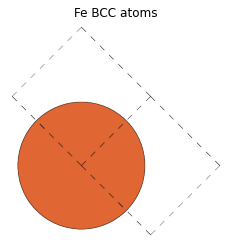

In [21]:
from ase.build import bulk
from pfcc_extras.visualize.ase import view_ase_atoms

fe_bcc = bulk("Fe")
view_ase_atoms(fe_bcc, figsize=(4, 4), title="Fe BCC atoms", scale=100, rotation="0x,0y,0z")

In [22]:
# view_ngl(fe_bcc)

In [23]:
print("fe_bcc Bravais lattice:", fe_bcc.cell.get_bravais_lattice())
print("fe_bcc cell           :", fe_bcc.cell)

fe_bcc Bravais lattice: BCC(a=2.87)
fe_bcc cell           : Cell([[-1.435, 1.435, 1.435], [1.435, -1.435, 1.435], [1.435, 1.435, -1.435]])


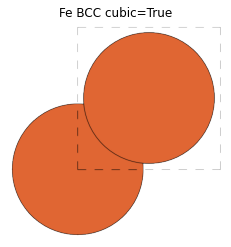

In [24]:
fe_cubic = bulk("Fe", cubic=True)
view_ase_atoms(fe_cubic, figsize=(4, 4), title="Fe BCC cubic=True", scale=100, rotation="0x,0y,0z")

In [25]:
# view_ngl(fe_cubic)

In [26]:
print("fe_cubic Bravais lattice:", fe_cubic.cell.get_bravais_lattice())
print("fe_cubic cell           :", fe_cubic.cell)

fe_cubic Bravais lattice: CUB(a=2.87)
fe_cubic cell           : Cell([2.87, 2.87, 2.87])


## 参考文献

空間群について、より詳しく勉強したい方は以下が参考になるでしょう。

 - 「物質の対称性と群論」 今野 豊彦